# Разработка A/B-тестирования и анализ результатов

Запрос на проведение А/В-теста от компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Меня, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Даны три таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. 

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. 

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Задачи: 
- рассчитать параметры теста
- оценить корректность его проведения
- проанализировать результаты эксперимента

В рамках теста будет оцениваться метрика `доля успешных сессий`, ожидается ее повышение. Также будет протестирована метрика `количество уникальных дневных сессий` по группам, ожидается, что она останется не изменной.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
# загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt

from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# загружаем файл в датафрейм
part_path = 'C:/Files/Ya_Practicum/Projects/Project_11/'
sessions_history = pd.read_csv(part_path + 'sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

- Выведим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [3]:
# отфильтруем таблицу по пользователю с максимаьным кол-вом сессий (самым часто встречающимся пользователем)
sessions_history[sessions_history.user_id == sessions_history['user_id'].value_counts().idxmax()]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


Видим, что сессия №1 совпадает по дате с датой установки приложения, далее номера сессий идут по возрастанию. Для каждой сессии есть дата и время начала сессии, а также кол-во посещенных страниц. Также есть столбец с регионом пользователя и столбец с типом устройсва, с которого совершалась сессия.

---

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [4]:
# сделаем маску по первому в день времени входа пользоателя в приложение
mask = sessions_history['session_start_ts'] == sessions_history.groupby(['user_id', 'session_date'])['session_start_ts'].transform('min')
# отфильтруем данные по маске
df_filtered = sessions_history[mask]
# сгруппирум отфильтрованные данные по дате и посчитаем кол-во уникальных пользователей и зарегистрированных пользователей
users_by_days = df_filtered.groupby('session_date').agg(
                                unique_users=('user_id', 'nunique'),
                                reg_users=('registration_flag', lambda x: (x==1).sum())
                                ).reset_index()

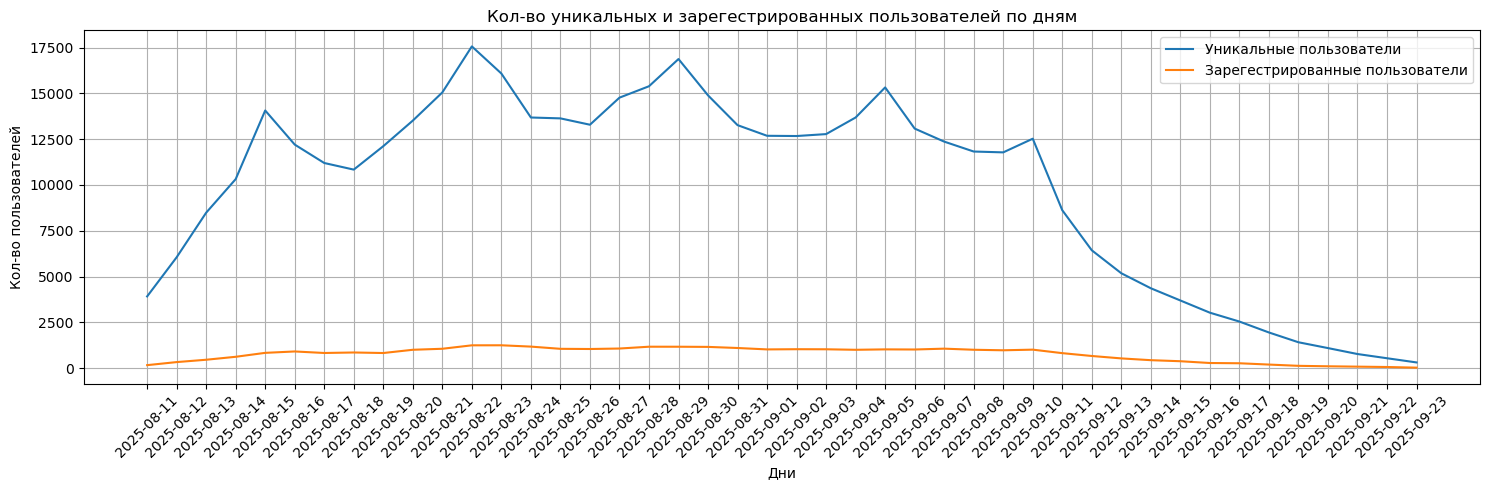

In [5]:
# построим график по этим данным
plt.figure(figsize=(15,5))
plt.plot(users_by_days.session_date, users_by_days.unique_users, label='Уникальные пользователи')
plt.plot(users_by_days.session_date, users_by_days.reg_users, label='Зарегестрированные пользователи')
plt.title('Кол-во уникальных и зарегестрированных пользователей по дням')
plt.xlabel('Дни')
plt.ylabel('Кол-во пользователей')
plt.legend()
plt.xticks(rotation=45)  # поворот дат для читаемости
plt.tight_layout()
plt.grid()
plt.show()

Видим, что зарегистрированнх пользователей сильно меньше общего числа пользователей. Есть 5 пиков кол-ва пользоватерей в день - возможно, это недельные колебания. Есть рост кол-ва с начала данных до 21 августа 2025, после чего идет тренд на снижение активности пользователей (максимумы и минимумы снижаются). В конце виден сильный спад кол-ва пользователей.

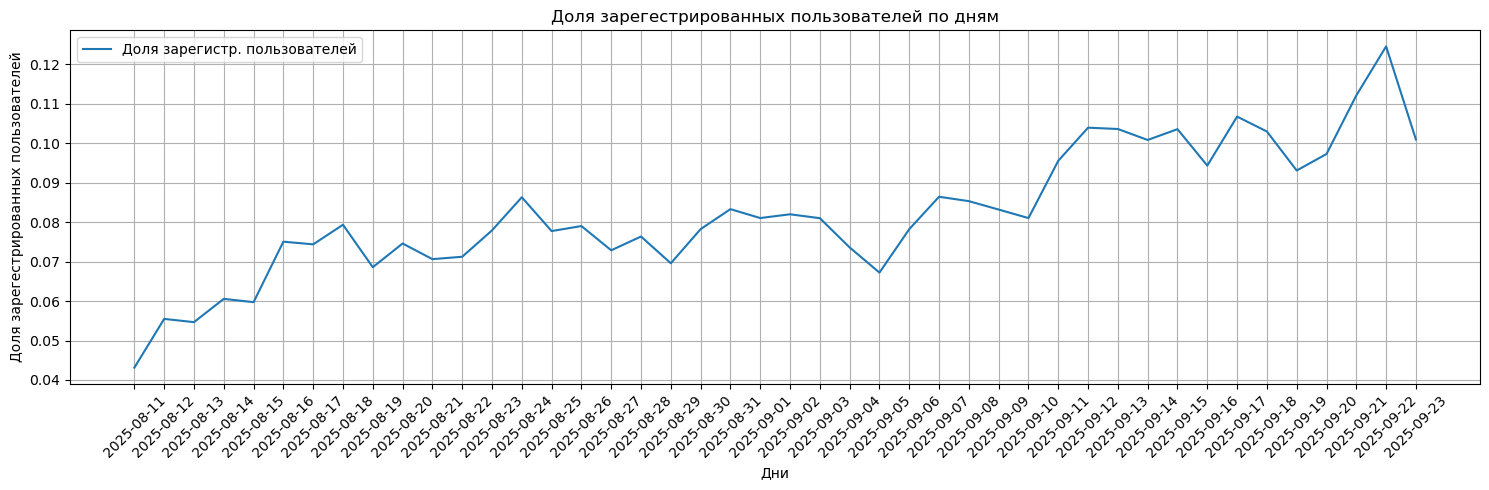

In [6]:
# построим график доли зарегистрированных пользователей от всех уникальных пользователей по дням
plt.figure(figsize=(15,5))
plt.plot(users_by_days.session_date, (users_by_days.reg_users / users_by_days.unique_users), label='Доля зарегистр. пользователей')
plt.title('Доля зарегестрированных пользователей по дням')
plt.xlabel('Дни')
plt.ylabel('Доля зарегестрированных пользователей')
plt.legend()
plt.xticks(rotation=45)  # поворот дат для читаемости
plt.tight_layout()
plt.grid()
plt.show()

Видим, что доля зарегистрированнх пользователей растет - за исследуемый период времени доля выросла с 4,5% до более 12% (максимум графика).

**Промежуточный вывод**

Есть рост кол-ва пользователей до 21 августа 2025г., потом тренд на снижение пользователей - как зарегистрированных, так и не зарегистрированных. Наблюдается недельная цикличность посещаемости приложения. Есть общий спад посещаемости (особенно в конце наблюдений). Поэтому и доля зарегестрированнх растет, т.к. пользователей в конце становится сильно меньше.

---

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. 

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [7]:
# сгруппируем данные по кол-ву просмотров страниц и посчитаем кол-во сессий для каждого значения простмотра
df_pages = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
df_pages

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


<Figure size 1000x400 with 0 Axes>

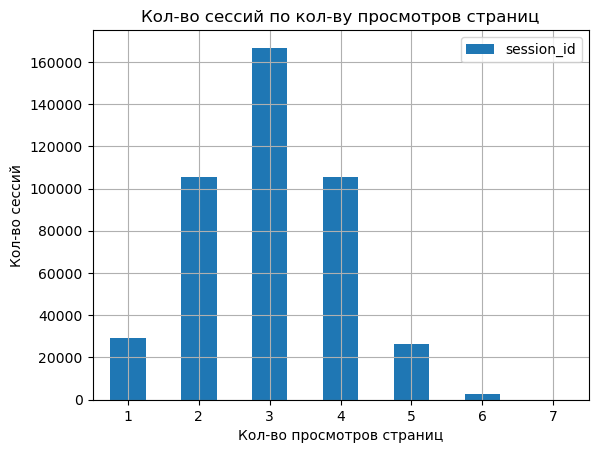

In [8]:
# построим столбчатую диаграмму
plt.figure(figsize=(10,4))
df_pages.plot(kind='bar', x='page_counter', y='session_id', rot=0)
plt.title('Кол-во сессий по кол-ву просмотров страниц')
plt.xlabel('Кол-во просмотров страниц')
plt.ylabel('Кол-во сессий')
plt.grid()
plt.show()

Видим почти нормальное распределение, больше всего сессий с просмотром 3 страниц за сессию.

---

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [9]:
# создадим столбец good_session, где 1 - просмотрено 4 и более страниц, 0 - меньше 4.
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype('int')
# сгруппируем данные по дате и посчитаем кол-во успешных сессий, общее кол-во сессий
df_good_sess = sessions_history.groupby(['session_date', 'user_id']).agg(
                                        sessions_cnt=('session_id', 'count'),
                                        good_sessions_cnt=('good_session', 'sum')
                                        ).reset_index()
#создадим столбец с долей успешных сессий
df_good_sess['share_good_sessions'] = df_good_sess['good_sessions_cnt']/df_good_sess['sessions_cnt']
# сгруппируем данные по дате и посчитаем среднее доли успешных сессий
df_avg_share_good_sess = df_good_sess.groupby('session_date')['share_good_sessions'].mean().reset_index()

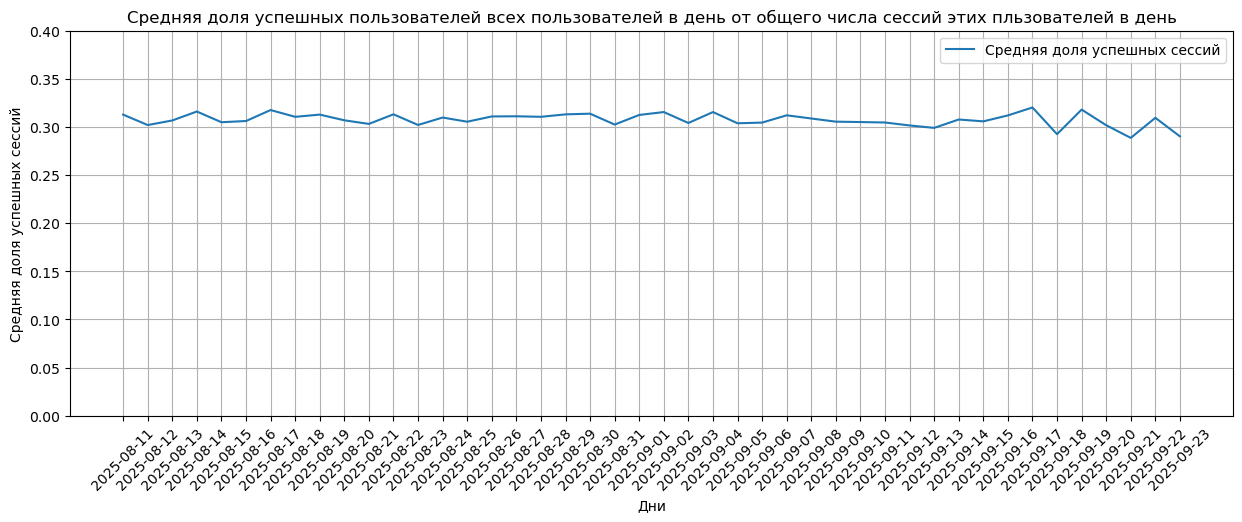

In [10]:
# построим график средней доли успешных сессий по дням
plt.figure(figsize=(15,5))
plt.plot(df_avg_share_good_sess.session_date, df_avg_share_good_sess.share_good_sessions, label='Средняя доля успешных сессий')
plt.title('Средняя доля успешных пользователей всех пользователей в день от общего числа сессий этих пльзователей в день')
plt.xlabel('Дни')
plt.ylabel('Средняя доля успешных сессий')
plt.legend()
plt.xticks(rotation=45)  # поворот дат для читаемости
plt.ylim(0,0.4)
plt.grid()
plt.show()

Видим, что в среднем, доля успешных сессий по пользователям в день выше 30% почти все время наблюдений, только во второй половине сентября 2025г. начинает снижаться ниже этой отметки (минимум 28,9%). Максимум средней доли - 32%.

Также заметна цикличность данных (возможно, недельная), поэтому для теста лучше брать число дней, кратное неделе.

---

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Главная метрика для проверки гипотезы - **доля успешных сессий** (как предполагают разработчики, новый алгоритм подтолкнет пользователей к большему кол-ву просмотров, т.е. к увеличению кол-ва просмотренных страниц).

Формулиуем нулевую и альтернативную гипотезы:

$Н_{0}$ - доля успешных сессий не изменилась.  
$Н_{1}$ - доля успешных сессий стала больше.

---

#### 2.2. Расчёт размера выборки

Для рассчета размера выборки установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода $\beta$ — 0.2.

- Мощность теста $1 - \beta$ — 0.8.

- Минимальный детектируемый эффект, или MDE, — 3%.

- Базовый уровень метрики - 0.3 (типичное значение, которое мы получили для доли успешных сессий).

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [11]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p   # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [12]:
# среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(41040 * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 9 дней


Минимальное кол-во дней для теста - 9 дней, но лучше провести его 14 дней (кратно неделе, как говорилось выше).

Решено проводить тест 20 дней, за счет этого общее число участников увеличится и мощность теста останется высокой. Это значит, что вероятность не заметить реальный эффект крайне мала.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первый день. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведиме на экран процентную разницу в количестве пользователей в группах A и B.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [13]:
# загружаем данные за первые дни теста
sessions_test_part = pd.read_csv(part_path + 'sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [14]:
# посмотрим, сколько дней теста в таблице
sessions_test_part['session_date'].unique()

array(['2025-10-14'], dtype=object)

Всего 1 день 14 октября 2025г. предствлен в таблице.

In [15]:
# посчитаем кол-во уникальных пользователей для групп А и В
users_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].user_id.nunique()
users_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].user_id.nunique()
print(f'В группе А {users_a} пользователей, в групп В {users_b} пользователей.')

В группе А 1477 пользователей, в групп В 1466 пользователей.


In [16]:
# рассчитаем процентную долю разницы кол-ва пользователей в группах
dif_per = round(100 * abs(users_a - users_b) / users_a, 2)
print(f'Разница между группами А и В составляет {dif_per}%.')

Разница между группами А и В составляет 0.74%.


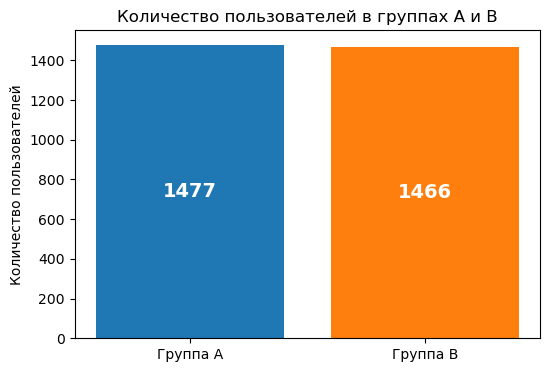

In [17]:
# построим график кол-ва пользователей в группах А и В
groups = ['Группа А', 'Группа В']
users = [1477, 1466]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(groups, users, color=['#1f77b4', '#ff7f0e'])

# Добавляем количество пользователей в центре колонок, белым жирным шрифтом
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(height),
            ha='center', va='center', color='white', fontsize=14, fontweight='bold')

ax.set_title('Количество пользователей в группах A и B')
ax.set_ylabel('Количество пользователей')

plt.show()

Видим, что кол-во пользователей в группах А и В почти одинаковые (разница 0,74%, что допустимо для продолжения теста).

---

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Сгруппируем по пользователю и посчитаем названия групп для каждого пользователя. Если будет больше 1, то есть пересечение, если нет - то нет пересечений.

In [18]:
intersection = sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1').test_group.sum()
if intersection == 0:
    print('Пересечений в группах нет')
else:
    print('Есть пересечения')

Пересечений в группах нет


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

In [19]:
# сгруппируем пользователей по типу устройства в каждой группы
device_grp_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().reset_index()
device_grp_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device').user_id.nunique().reset_index()
# добавим в группы столбец с долей устройств
device_grp_a['device_share'] = device_grp_a.user_id / device_grp_a.user_id.sum()
device_grp_b['device_share'] = device_grp_b.user_id / device_grp_b.user_id.sum()
print(f'Распределение по устройствам в группе А: \n{device_grp_a} \n Итого: {device_grp_a.user_id.sum()}\n')
print(f'Распределение по устройствам в группе В: \n{device_grp_b}\n Итого: {device_grp_b.user_id.sum()}')

Распределение по устройствам в группе А: 
    device  user_id  device_share
0  Android      656      0.444144
1      Mac      156      0.105619
2       PC      369      0.249831
3   iPhone      296      0.200406 
 Итого: 1477

Распределение по устройствам в группе В: 
    device  user_id  device_share
0  Android      668      0.455662
1      Mac      148      0.100955
2       PC      381      0.259891
3   iPhone      269      0.183492
 Итого: 1466


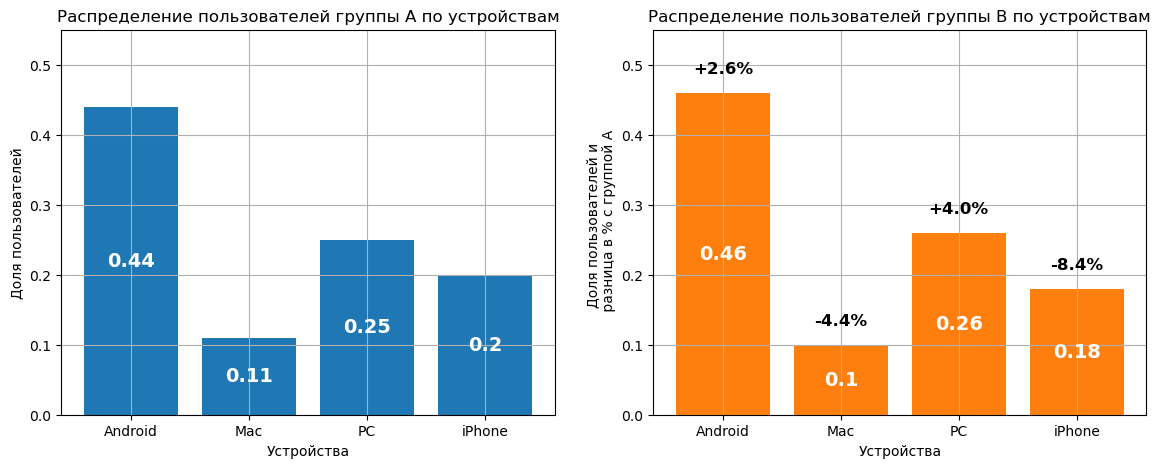

In [20]:
# построим столбчатые диаграммы распределения групп по устройствам
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))

bars1 = ax1.bar(device_grp_a.device, round(device_grp_a.device_share,2), color='#1f77b4')
ax1.set_title('Распределение пользователей группы А по устройствам')
ax1.set_ylabel('Доля пользователей')
ax1.set_xlabel('Устройства')
ax1.grid()
ax1.set_ylim(0, 0.55)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height / 2, str(height),
            ha='center', va='center', color='white', fontsize=14, fontweight='bold')

bars2 = ax2.bar(device_grp_b.device, round(device_grp_b.device_share,2), color='#ff7f0e')
ax2.set_title('Распределение пользователей группы B по устройствам')
ax2.set_ylabel('Доля пользователей и \n разница в % с группой А')
ax2.set_xlabel('Устройства')
ax2.grid()
ax2.set_ylim(0, 0.55)

# Рассчитываем процентную разницу и добавляем над столбцами
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height / 2, str(height),
            ha='center', va='center', color='white', fontsize=14, fontweight='bold')

    a_value = device_grp_a.device_share.iloc[i]
    b_value = device_grp_b.device_share.iloc[i]
    if a_value != 0:
        diff_percent = ((b_value - a_value) / a_value) * 100
        diff_text = f"{diff_percent:+.1f}%"
    else:
        diff_text = "N/A"

    ax2.text(bar.get_x() + bar.get_width() / 2, height + max(device_grp_b.device_share)*0.05, diff_text,
            ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

plt.show()

Видим, что распределения по устройствам похожи (распределены равномерно):
- максимальная разница 4,0% в группе В у пользователей с РС
- минимальная разница -8,4% в группе В у пользователей с iPhone
---

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

In [21]:
# сгруппируем пользователей по региону в каждой группы
region_grp_a = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().reset_index()
region_grp_b = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region').user_id.nunique().reset_index()
# добавим столбец с долей региона в каждую группу
region_grp_a['region_share'] = region_grp_a.user_id / region_grp_a.user_id.sum()
region_grp_b['region_share'] = region_grp_b.user_id / region_grp_b.user_id.sum()
print(f'Распределение по региону в группе А: \n{region_grp_a}\n Итого: {region_grp_a.user_id.sum()} \n')
print(f'Распределение по региону в группе В: \n{region_grp_b}\n Итого: {region_grp_b.user_id.sum()} \n')

Распределение по региону в группе А: 
  region  user_id  region_share
0    CIS      644      0.436019
1     EU      224      0.151659
2   MENA      609      0.412322
 Итого: 1477 

Распределение по региону в группе В: 
  region  user_id  region_share
0    CIS      645      0.439973
1     EU      217      0.148022
2   MENA      604      0.412005
 Итого: 1466 



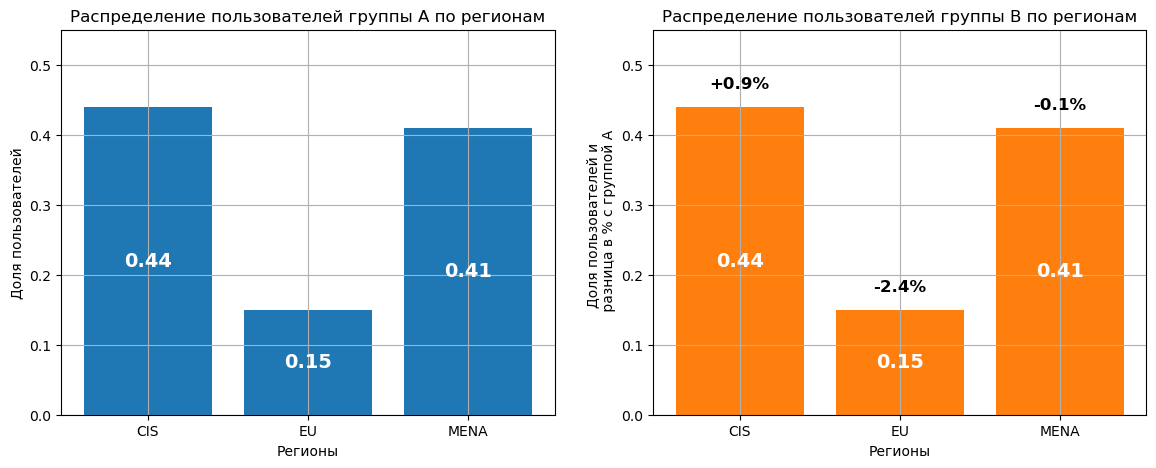

In [22]:
# построим столбчатые диаграммы распределения групп по регионам
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))

bars1 = ax1.bar(region_grp_a.region, round(region_grp_a.region_share,2), color='#1f77b4')
ax1.set_title('Распределение пользователей группы А по регионам')
ax1.set_ylabel('Доля пользователей')
ax1.set_xlabel('Регионы')
ax1.grid()
ax1.set_ylim(0, 0.55)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height / 2, str(height),
            ha='center', va='center', color='white', fontsize=14, fontweight='bold')

bars2 = ax2.bar(region_grp_b.region, round(region_grp_b.region_share,2), color='#ff7f0e')
ax2.set_title('Распределение пользователей группы B по регионам')
ax2.set_ylabel('Доля пользователей и \n разница в % с группой А')
ax2.set_xlabel('Регионы')
ax2.grid()
ax2.set_ylim(0, 0.55)

# Рассчитываем процентную разницу и добавляем над столбцами
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height / 2, str(height),
            ha='center', va='center', color='white', fontsize=14, fontweight='bold')

    a_value = region_grp_a.region_share.iloc[i]
    b_value = region_grp_b.region_share.iloc[i]
    if a_value != 0:
        diff_percent = ((b_value - a_value) / a_value) * 100
        diff_text = f"{diff_percent:+.1f}%"
    else:
        diff_text = "N/A"

    ax2.text(bar.get_x() + bar.get_width() / 2, height + max(region_grp_b.region_share)*0.05, diff_text,
            ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

plt.show()

Видим, что распределения по регионам похожи (распределены равномерно):
- максимальная разница 0,9% в группе В у пользователей из СНГ
- минимальная разница -2,4% в группе В у пользователей из Европы
---

#### 3.5. Вывод после проверки A/B-теста

В ходе проверки одного дня теста было выявлено:
- в группе А 1477 пользователей, в группе В - 1466, разница всего в 0,74%
- группы А и В являются незваисимыми - пересечений по пользователям в группах не обнаружено
- равномерное распределение в группах сохраняется по категориальным переменным: устройствам и регионам.

**Вывод**  

А/В-тест проходит корректно, можно продолжать.

---

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [23]:
# загружаем результаты теста
sessions_test = pd.read_csv(part_path + 'sessions_project_test.csv')

In [24]:
# добавим столбец good_session, равный 1, если посещенных страниц >= 4, и 0, если меньше
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype('int')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

Чтобы провести статистический тест о кол-ве уникальных дневных сессий в двух выборках сформируем сначала нулевую и альтернативную гипотезы:

$H_{0}$ - кол-ва уникальных дневных сессий в контрольной и тестовой группах `не различаются`.  
$H_{1}$ - кол-ва уникальных дневных сессий в котрольной и тестовой группах `различаются`.

In [25]:
# расситаем кол-во уникальных сессий для каждой группы по дням
sessions_a = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date').session_id.nunique().reset_index()
sessions_b = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date').session_id.nunique().reset_index()
# посчитаем статистику по 2м выборкам
results = ttest_ind(sessions_a.session_id, sessions_b.session_id, alternative='two-sided') # смотрим есть ли вообще отличия
print(f'p-значение = {round(results.pvalue, 3)}')

p-значение = 0.938


p-значение почти 94%, это говорит об отстутствии статистически значимых различий между выборками и у нас нет оснований отвергать нулевую гипотезу.

---

#### 4.3. Сравнение доли успешных сессий

Теперь, когда мы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [26]:
# проверим, все ли сессии в данных теста уникальны
sess_dupl = sessions_test.session_id.duplicated().sum()
if sess_dupl == 0:
    print('Все сессии в тесте уникальны (нет дубликатов)')
else:
    print(f'В данных теста есть не уникальные сессии (дубликаты): {sess_dupl} шт.')

Все сессии в тесте уникальны (нет дубликатов)


In [27]:
# посчитаем кол-во успешных сессий для каждой группы
good_sess_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
good_sess_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()
# посчитаем общее кол-во сессий в каждой группе
sess_a_cnt = len(sessions_test[sessions_test['test_group'] == 'A'])
sess_b_cnt = len(sessions_test[sessions_test['test_group'] == 'B'])
# посчитаем доли успешних сессий для каждой группы
gs_a_share = good_sess_a / sess_a_cnt
gs_b_share = good_sess_b / sess_b_cnt
# выводим результаты на экран
print(f'Доля успешных сессий в группе А: {round(gs_a_share,3)} \n')
print(f'Доля успешных сессий в группу В: {round(gs_b_share,3)} \n')
print(f'Разница долей успешных сессий между группами составляет: {round(abs(gs_a_share - gs_b_share),3)}')

Доля успешных сессий в группе А: 0.308 

Доля успешных сессий в группу В: 0.318 

Разница долей успешных сессий между группами составляет: 0.011


Доля успешных сессий в тестовой группе выше на 1,1%. Это может говорить о том, что изменения алгоритма рекомендаций, протестированное в этой группе, положительно повлияли на пользовательский опыт. А значит, они могут быть внедрены в основную версию продукта.

Но сначала нужно убедиться, является ли такое изменение статистически значимым, или это может быть случаное колебание метрики.

---

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

Т.к. у нас метрика долевая, то считать статистику будем через z-тест пропорций.

In [28]:
# посчитаем z-тест пропорции
count = [good_sess_a, good_sess_b]
nobs = [sess_a_cnt, sess_b_cnt]
stat, p_value_zt = proportions_ztest(count, nobs)
print(f'p-значение = {round(p_value_zt,5)}')
if p_value_zt >= alpha:
    print('Статистически значимых различий нет, оставляем нулевую гипотезу')
else:
    print('Статистически значимые различия есть, отвергаем нулевую гипотезу')

p-значение = 0.00031
Статистически значимые различия есть, отвергаем нулевую гипотезу


#### 4.5. Вывод по результатам A/B-эксперимента

In [29]:
# посчитаем, сколько уникальных пользователей участвовало в эксперименте
test_unique_users = sessions_test.user_id.nunique()
# посчитаем, сколько длился эксперимент
test_duration = (pd.to_datetime(sessions_test['session_date']).max() - pd.to_datetime(sessions_test['session_date']).min()).days
# посчитаем, сколько суммарно за каждый день эксперимента получилось участников в каждой группе
all_users_a = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date').user_id.nunique().sum()
all_users_b = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date').user_id.nunique().sum()
print(f'В эксперименте приняло участие {test_unique_users} уникальных пользователей')
print(f'Эксперимент длился {1 + test_duration} дней.') # 1 день в таблице sessions_test_part и остальные дни в таблице sessions_test
print(f'Группа А набрала за это время суммарно по дням {all_users_a} пользователей.')
print(f'Группа B набрала за это время суммарно по дням {all_users_b} пользователей.')
print(f'Суммарно за все время эксперимента было набрано {all_users_a + all_users_b} пользователей.')

В эксперименте приняло участие 30579 уникальных пользователей
Эксперимент длился 20 дней.
Группа А набрала за это время суммарно по дням 49242 пользователей.
Группа B набрала за это время суммарно по дням 49929 пользователей.
Суммарно за все время эксперимента было набрано 99171 пользователей.


**Параметры эксперимента**

По рассчетам в эксперименте должно было быть задействовано минимум 82080 пользователей (по 41040 в контрольной и тестовой группах).
Длиться эксперимент должен был минимум 9 дней.

Реальный эксперимент набрал 99171 пользователя (49242 в контрольной группе, 49929 в тестовой группе) и длился 20 дней.

**Итоги эксперимента**

А/В-тест для метрики `доля успешных сессий` показал p-значение 0.00031, что является статистически значимым и позволило нам отклонить нулевую версию в пользу альтернативной - что новый алгоритм увеличил эту метрику. 

По результатам расчетов метрика `доля успешных сессий` выросла на 1,1%. Такой результат можно было бы отнести к разбросу стреднего, но статистическая проверка гипотезы показывает, что здесь статистически значимое различие, т.е. можно принять, что введение нового алгоритмя повлияло на увеличение метрики.

**Рекомендация**

Стоит внедрять новый алгоритм в приложение.